import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import jinja2
import csv

In [3]:
with open("income_dist.csv", "r") as csvfile:
    reader = csv.DictReader(csvfile)
    data = list(reader)

In [5]:
print len(data)
print len(reader.fieldnames)

2180
354


In [6]:
income = "income_dist.csv"

More memory-efficient implementation of reading in a dataset. Also allow for filtering based on a given filter_value in a filter_field.

In [13]:
def dataset(path, filter_field = None, filter_value = None):
    with open(path, "r") as csvfile:
        reader = csv.DictReader(csvfile)
        if filter_field:
            for row in filter(lambda row: row[filter_field] == filter_value, reader):
                yield row
        else:
            for row in reader:
                yield row

In [8]:
print set([row["Country"] for row in dataset(income)])

set(['Canada', 'Italy', 'France', 'Netherlands', 'Ireland', 'Argentina', 'Norway', 'Australia', 'Singapore', 'China', 'Germany', 'Spain', 'Finland', 'Denmark', 'Tanzania', 'Indonesia', 'Mauritius', 'Sweden', 'Switzerland', 'New Zealand', 'United States', 'Portugal', 'South Africa', 'India', 'United Kingdom', 'Japan'])


In [9]:
print "Number of countries in dataset:", len(set([row["Country"] for row in dataset(income)]))

Number of countries in dataset: 26


In [12]:
print "Earliest year in dataset:", min(set([int(row["Year"]) for row in dataset(income)]))
print "Most recent year in dataset:", max(set(int(row["Year"]) for row in dataset(income)))

 Earliest year in dataset: 1875
Most recent year in dataset: 2010


In [36]:
def main(path):
    data = [(row["Year"], float(row["Average income per tax unit"])) for row in dataset(path, "Country", "United States")]
    
    width = 0.35
    ind = np.arange(len(data))
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.bar(ind, list(d[1] for d in data))
    ax.set_xticks(np.arange(0, len(data), 6))
    ax.set_xticklabels(list(d[0] for d in data)[0::6], rotation = 45)
    ax.set_ylabel("Income in USD")
    plt.title("U.S. Average Income 1913 - 2008")
    plt.show()

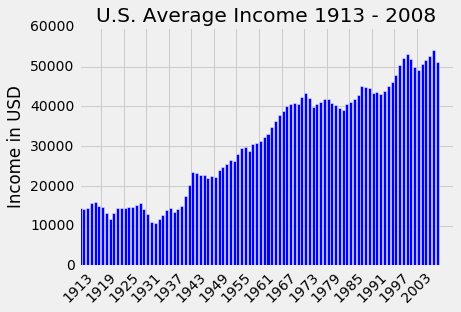

In [37]:
main("income_dist.csv")

In [29]:
names = ["country", "year"]
names.extend(["col%i" % (idx+1) for idx in xrange(352)])
dtype = "U64,i4," + ",".join(["f18" for idx in xrange(352)])

In [31]:
#df = np.genfromtxt("income_dist.csv", dtype=dtype, names=names, delimiter=",", skip_header=1, autostrip=2)

Extract data fro the country indicated, United States is the default value.

In [38]:
def dataCountry(path, country="United States"):
    with open(path, "r") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in filter(lambda row: row["Country"] == country, reader):
            yield row

Create a year-based time series for the given column.

In [39]:
def timeseries(data, column):
    for row in filter(lambda row: row[column], data):
        yield (int(row["Year"]), row[column])

In [56]:
def linechart(series, **kwargs):
    fig = plt.figure(figsize=(9, 9))
    ax = plt.subplot(111)
    
    for line in series:
        line = list(line)
        xvals = [v[0] for v in line]
        yvals = [v[1] for v in line]
        ax.plot(xvals, yvals)
        
    if "ylabel" in kwargs:
        ax.set_ylabel(kwargs["ylabel"])
        
    if "title" in kwargs:
        plt.title(kwargs["title"])
    
    if "labels" in kwargs:
        ax.legend(kwargs.get("labels"), fontsize=8.5)
    return fig

In [63]:
def normalize(data):
    data = list(data)
    norm = np.array(list(d[1] for d in data), dtype="f8")
    mean = norm.mean()
    norm /= mean
    return zip((d[0] for d in data), norm)

In [62]:
def percent_income_share(source, normalized = False):
    columns = ("Top 10% income share", "Top 5% income share", "Top 1% income share", 
               "Top 0.5% income share", "Top 0.1% income share")
    source = list(dataCountry(source))
    if normalized:
        return linechart([normalize(timeseries(source, col)) for col in columns], labels=columns, 
                     title="U.S. Percentage Income Share", ylabel="Percentage")
    else:
        return linechart([timeseries(source, col) for col in columns], labels=columns, 
                     title="U.S. Percentage Income Share", ylabel="Percentage")

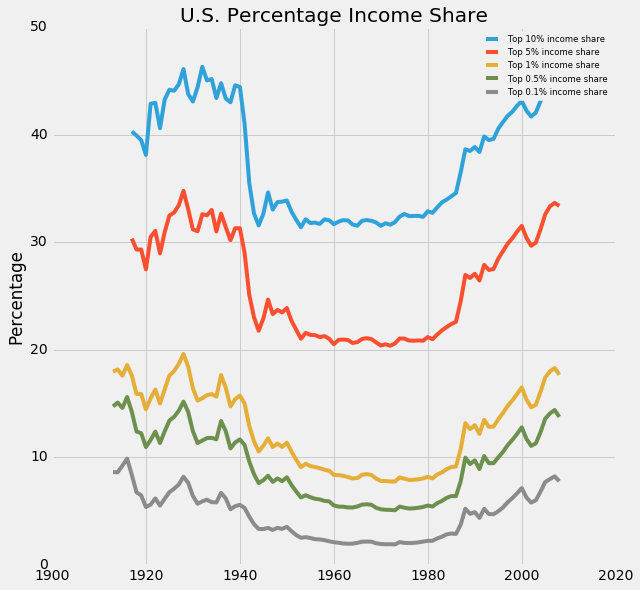

In [57]:
percent_income_share("income_dist.csv")
plt.show()

Create a function to normalize data.

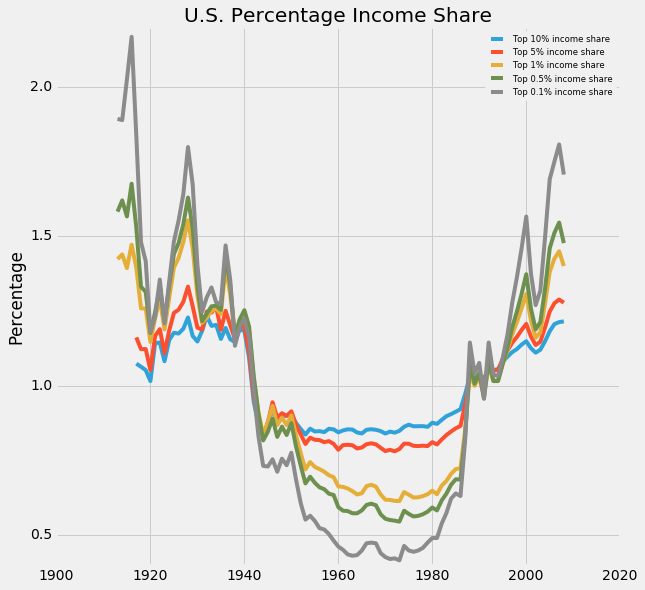

In [73]:
percent_income_share("income_dist.csv", normalized=True)
plt.show()

In [65]:
def yrange(data):
    years = set()
    for row in data:
        if row[0] not in years:
            yield row[0]
            years.add(row[0])

In [66]:
def delta(first, second):
    first = list(first)
    years = yrange(first)
    first = np.array(list(d[1] for d in first), dtype="f8")
    second = np.array(list(d[1] for d in second), dtype="f8")
    
    if first.size != second.size:
        first = np.insert(first, [0, 0, 0, 0], [None, None, None, None])
    diff = first - second
    return zip(years, diff)

In [68]:
def capital_gains_left(source):
    columns = (("Top 10% income share-including capital gains", "Top 10% income share"), 
               ("Top 5% income share-including capital gains", "Top 5% income share"),
                ("Top 1% income share-including capital gains", "Top 1% income share"),
            ("Top 0.5% income share-including capital gains", "Top 0.5% income share"),
        ("Top 0.1% income share-including capital gains", "Top 0.1% income share"),
    ("Top 0.05% income share-including capital gains", "Top 0.05% income share"))
    source = list(dataCountry(source))
    series = [delta(timeseries(source, a), timeseries(source, b)) for a, b in columns]
    return linechart(series, labels=list(col[1] for col in columns), title="U.S. Capital Gains Income Lift",
                    ylabel="Percentage Difference")

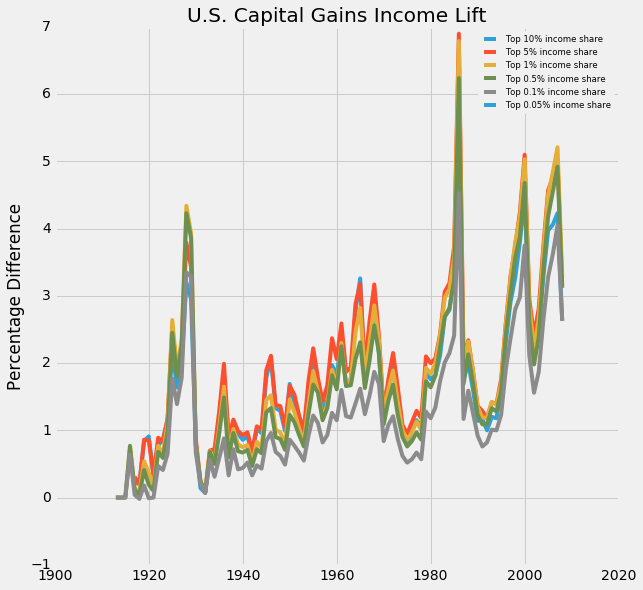

In [69]:
capital_gains_left("income_dist.csv")
plt.show()

Compare average income of different income brackets over time.

In [70]:
def average_income(source, country="United States"):
    columns = ("Top 10% average income", "Top 5% average income", "Top 1% average income", "Top 0.5% average income",
            "Top 0.1% average income", "Top 0.05% average income")
    source = list(dataCountry(source, country))
    return linechart([timeseries(source, col) for col in columns], labels=columns, title=country +" Average Income",
                    ylabel="Currency")

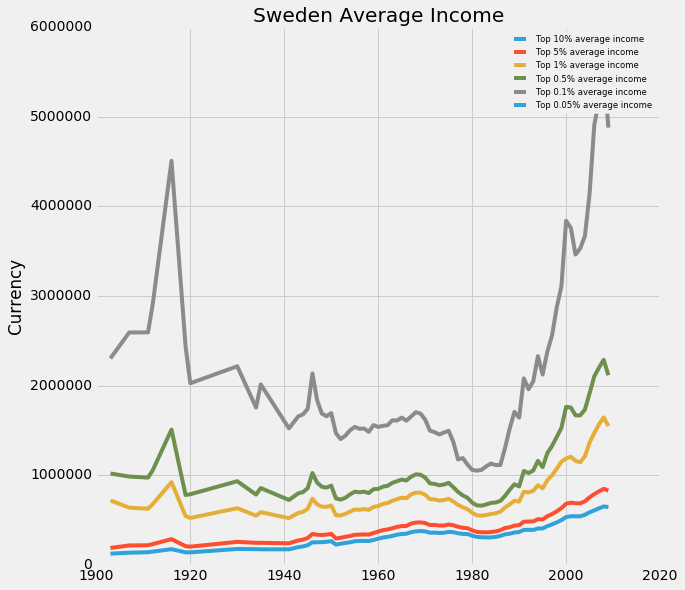

In [76]:
average_income("income_dist.csv", "Sweden")
plt.show()

Function to create a stacked area plot.

In [87]:
def stackedArea(series, **kwargs):
    fig = plt.figure(figsize=(9, 9))
    axe = fig.add_subplot(111)
    fnx = lambda s: np.array(list(v[1] for v in s), dtype="f8")
    yax = np.row_stack(fnx(s) for s in series)
    xax = np.arange(1917, 2008)
    
    polys = axe.stackplot(xax, yax)
    axe.margins(0, 0)
    
    if "ylabel" in kwargs:
        axe.set_ylabel(kwargs["ylabel"])
    if "labels" in kwargs:
        legendProxies = []
        for poly in polys:
            legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
        axe.legend(legendProxies, kwargs.get("labels"), fontsize=10, loc="lower right")
    if "title" in kwargs:
        plt.title(kwargs["title"])
    return fig

Examine income composition of wealthiest in country.

In [98]:
def income_composition(source, bracket=10, country="United States"):
    columns = ("% income composition-Wages, salaries and pensions", "% income composition-Dividends",
                "% income composition-Interest Income", "% income composition-Rents",
            "% income composition-Entrepreneurial income")
    columns = ("Top " + str(bracket) + c for c in columns)
    source = list(dataCountry(source, country))
    labels = ("Salary", "Dividends", "Interest", "Rent", "Business")
    return stackedArea([timeseries(source, col) for col in columns], labels=labels, 
                       title=country + " Top " +  str(bracket) + "% Income Composition", ylabel="Percentage")

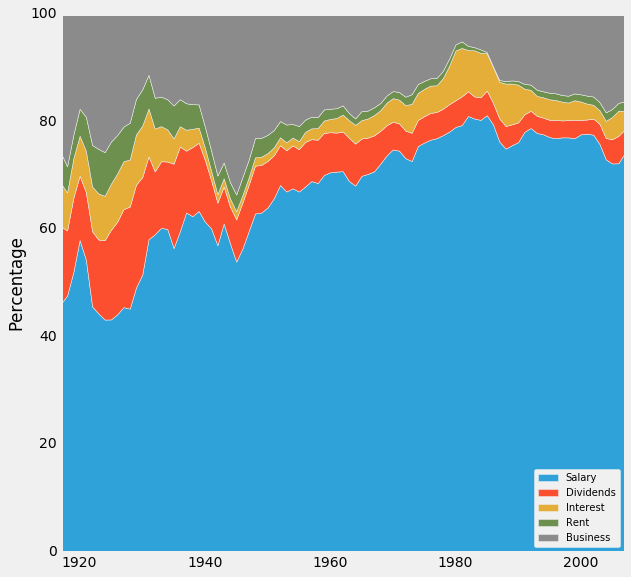

In [118]:
income_composition("income_dist.csv", 10, "United States")
plt.show()

In [119]:
from jinja2 import Template, Environment, PackageLoader, FileSystemLoader

In [120]:
template = Template(u'Greetings, {{ name }}!')
template.render(name="Mr. Praline")

u'Greetings, Mr. Praline!'